In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


In [10]:
# Dataset paths
base_dir = 'augmented_split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
IMG_SIZE = 256
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)
val_gen = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Class count
num_classes = train_gen.num_classes


Found 21421 images belonging to 10 classes.
Found 4586 images belonging to 10 classes.
Found 4602 images belonging to 10 classes.


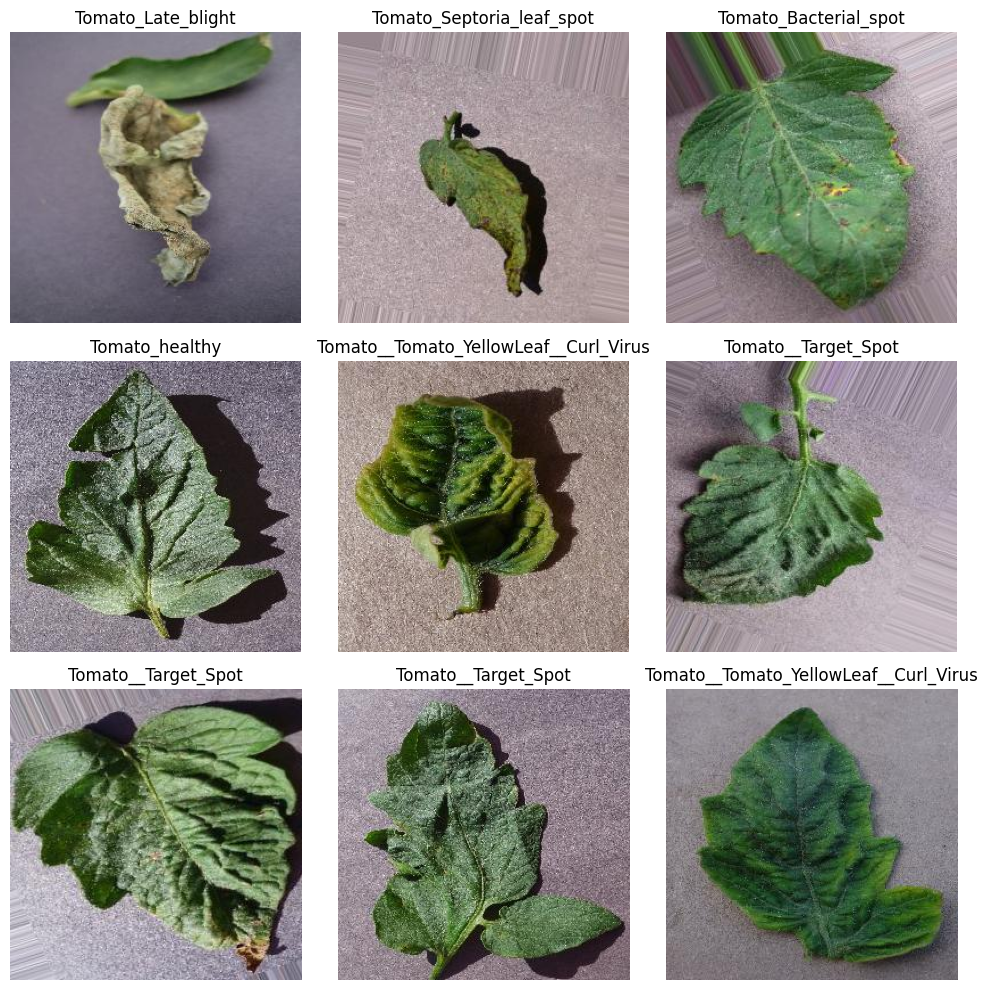

In [11]:
def show_sample_images(generator, num_images=9):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    labels_indices = np.argmax(labels, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels_indices[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_gen)


In [12]:
def build_cnn_model(input_shape=(256, 256, 3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),  # ✅ replaces Flatten to reduce 29M params
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# ✅ Compile model
model = build_cnn_model(input_shape=(256, 256, 3), num_classes=10)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Make sure labels are one-hot encoded!
    metrics=['accuracy']
)

# ✅ Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# ✅ Callbacks for stability
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# ✅ Fit model
history = model.fit(
    train_gen,                     # Ensure: class_mode='categorical'
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

Epoch 1/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.3996 - loss: 1.7285 - val_accuracy: 0.5495 - val_loss: 1.2506 - learning_rate: 1.0000e-04
Epoch 2/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 85s 127ms/step - accuracy: 0.6514 - loss: 0.9889 - val_accuracy: 0.8027 - val_loss: 0.6107 - learning_rate: 1.0000e-04
Epoch 3/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.7221 - loss: 0.8014 - val_accuracy: 0.8349 - val_loss: 0.5153 - learning_rate: 1.0000e-04
Epoch 4/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.7659 - loss: 0.6926 - val_accuracy: 0.8205 - val_loss: 0.5267 - learning_rate: 1.0000e-04
Epoch 5/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.7848 - loss: 0.6369 - val_accuracy: 0.8519 - val_loss: 0.4450 - learning_rate: 1.0000e-04
Epoch 6/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.8154 - loss: 0.5455 - val_accuracy: 0.8727 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 7/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/s

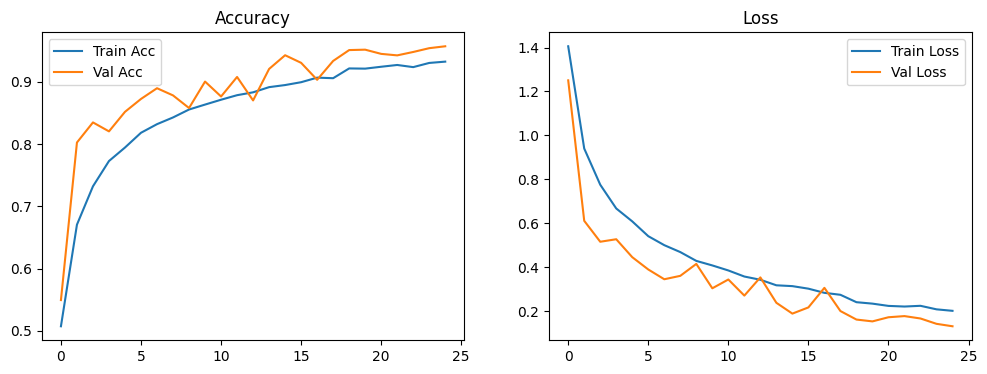

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [15]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2%}")


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9516 - loss: 0.1501
Test Accuracy: 96.02%
